# Decision Trees for Regression

In this notebook, we learn how decision trees can solve regression problems and how they are constructed.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz

In [2]:
# To install graphviz run: 
# ==> conda install python-graphviz
from graphviz import Source

## Decision Tree Regressor

As we have seen in the California Housing example, decision trees can be applied to regression tasks. In order to learn how decision tree can solve such regression problem, we will take a look at a simple example.

### Create sample dataset (Quadratic Function)

Let's assume we are given the following dataset composed of points sampled from a quadratic function. Our goal is to predict the values of the quadratic function with a decision tree regressor. In other words, we try to "fit" the quadratic function with our decision tree.

In [3]:
np.random.seed(42)

num_samples = 200
x = (np.random.rand(num_samples, 1) - 0.5)
y = x ** 2

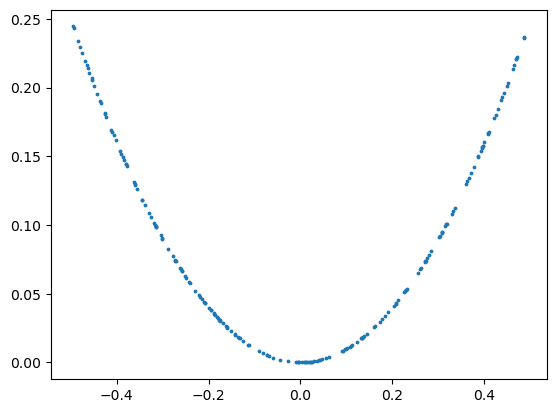

In [4]:
plt.scatter(x, y, s=3)
plt.show()

#### Visualizing a decision tree

We now train Scikit's `DecisionTreeRegressor` to predict the `y` value for each sample point `x`. To allow a better visualization of the decision tree, we restrict its maximum depth to 2.

In [5]:
# We use the Mean Squared error to determine the best split
# MSE is also used as the default
model = DecisionTreeRegressor(max_depth=2, criterion='squared_error')
model.fit(x, y)

DecisionTreeRegressor(max_depth=2)

Scikit's `export_graphviz()` method allows you to export a decision tree in DOT format. This function generates a GraphViz representation of the decision tree, which is then written into `out_file`. The DOT format is a graph description language developed as part of the Graphviz project.

In [6]:
export_graphviz(
    model,
    out_file=str("regression_tree.dot"),
    feature_names=["x"],
    rounded=True,
    filled=True
)

In order to visualize the graph, we can either use online tools such as https://edotor.net/ or the `graphviz` package to directly inspect the tree in the jupyter notebook.

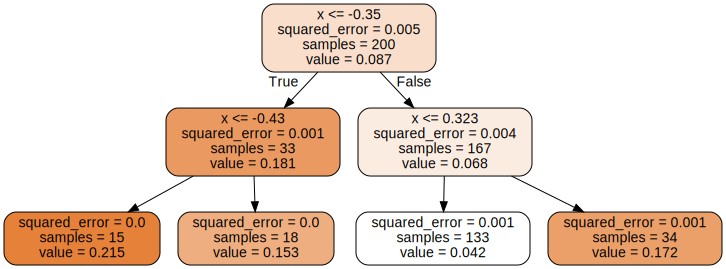

In [7]:
# Plot the tree with the graphviz module
Source.from_file("regression_tree.dot")

### How do we predict the value for a given x?

Given this tree, let's now suppose you want to make a prediction for a new sample with x = 0.31. We traverse
the tree starting at the root. We ask whether x<=-3.35, which is false and move to the root's right child node. We ask whether x <= 0.323, which is true. We move to the left child node and now have to stop since we reached a leave node. We return the mean y-value of all samples (which is 0.042) in the leaf node as our estimated value.

### Visualization of the prediction

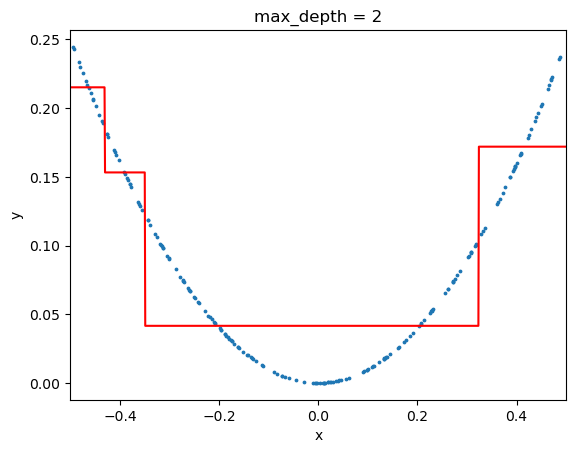

In [8]:
x_test = np.linspace(-0.5, 0.5, 1000).reshape(-1, 1)
y_pred = model.predict(x_test)

plt.plot(x_test, y_pred, c='r')

plt.xlim(-0.5, 0.5)
plt.scatter(x, y, s=3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('max_depth = 2')
plt.show()

### How do we determine the optimal split at each level?

We now understand how to "parse" a given decision tree in order to predict a value. However, we still haven't discussed how to construct the decision tree. That's what we will discuss next.

Scikit-Learn uses the **Classification And Regression Tree (CART)** algorithm to train Decision Trees (also called "growing" trees). The idea is really quite simple: the algorithm first splits the training set in two subsets using a *single* feature $k$ and a threshold $t_k$. How does it choose $k$ and $t_k$? It searches for the
pair $(k, t_k)$ that produces the lowest weighted cost $C(k, t_k)$.

$C(k, t_k) = \frac{n_{left}}{n} C_{left} + \frac{n_{right}}{n} C_{right}$

where $C_{left}$ and $C_{right}$ is some cost function computed on the left and right subset, $n_{left}$ and $n_{right}$ denotes the number of samples contained in the left and right subset, and $n$ denotes the total number of samples.

By default, Scikit uses the MSE (Mean Squared Error) as the cost function for regression problems. However, we can configure `DecisionTreeRegressor` a different metric such as the MAE (Mean Absolute Error) by setting `criterion` accordingly. Note that the choice of the splitting threshold depends on the chosen cost function. If we use the MSE as a cost function, the predicted value for a node becomes the mean of all samples in the node. However, if we use the MAE, the median of the node's samples is used. This is simply because choosing the mean value as the prediction results in the lowest possible MSE, while choosing the media value results in the lowest possible MAE.

Once it has successfully split the training set in two, it splits the subsets using the
same logic, then the sub-subsets and so on, recursively. It stops recursing once it reaches the maximum depth (defined by the `max_depth` hyperparameter), or if it cannot find a split that will reduce the costs.

**The following code illustrates how to determine the threshold for the root node:**

In [9]:
sort_idx = np.argsort(x, axis=0)
x_sorted = np.take_along_axis(x, sort_idx, axis=0)
y_sorted = np.take_along_axis(y, sort_idx, axis=0)

min_weighted_mse = np.inf
split_idx = -1

for i in range(1, y_sorted.shape[0]):

    # Get samples in left and right set
    y_left = y_sorted[:i]
    y_right = y_sorted[i:]
    
    # Number of samples in each set
    num_left = len(y_left)
    num_right = len(y_right)
    num_total = num_left + num_right
    
    # Estimated target value for each set
    pred_left = y_left.mean()
    pred_right = y_right.mean()
    
    # Compute MSE for each set
    mse_left = np.mean((y_left - pred_left) ** 2)
    mse_right = np.mean((y_right - pred_right) ** 2)
    
    weighted_mse = num_left / num_total * mse_left + num_right / num_total * mse_right
    
    if weighted_mse < min_weighted_mse:
        min_weighted_mse = weighted_mse
        split_idx = i

# Threshold = Value in between two samples
threshold = (x_sorted[split_idx-1, 0] + x_sorted[split_idx, 0]) / 2
left_pred = y_sorted[x_sorted <= threshold].mean()
right_pred = y_sorted[x_sorted > threshold].mean()

print(f'Threshold: {threshold:.3f}')
print('Num samples in left set:', (x <= threshold).sum())
print('Num samples in right set:', (x > threshold).sum())
print(f'Left Child - Estimated value: {left_pred:.3f}')
print(f'Right Child - Estimated value: {right_pred:.3f}')

Threshold: -0.350
Num samples in left set: 33
Num samples in right set: 167
Left Child - Estimated value: 0.181
Right Child - Estimated value: 0.068


### Regularization

In order to explore how we can regularize decision trees, let's first add some noise to our quadratic function to make it hard for the decision tree to fit the function.

In [10]:
np.random.seed(42)

num_samples = 200
x = (np.random.rand(num_samples, 1) - 0.5)
noise = np.random.randn(num_samples, 1)
y = x ** 2 + 0.025 * noise

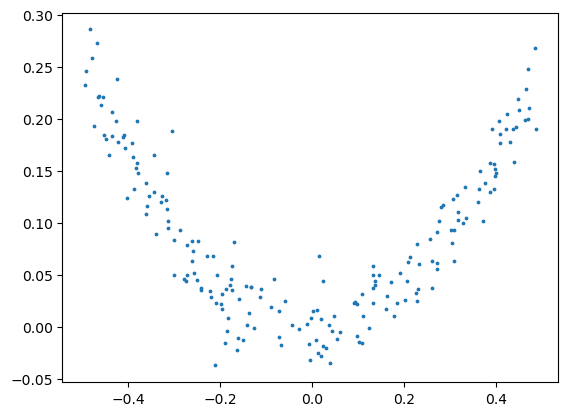

In [11]:
plt.scatter(x, y, s=3)
plt.show()

We now test decision trees of different depths in order to see how they "react" to noise.

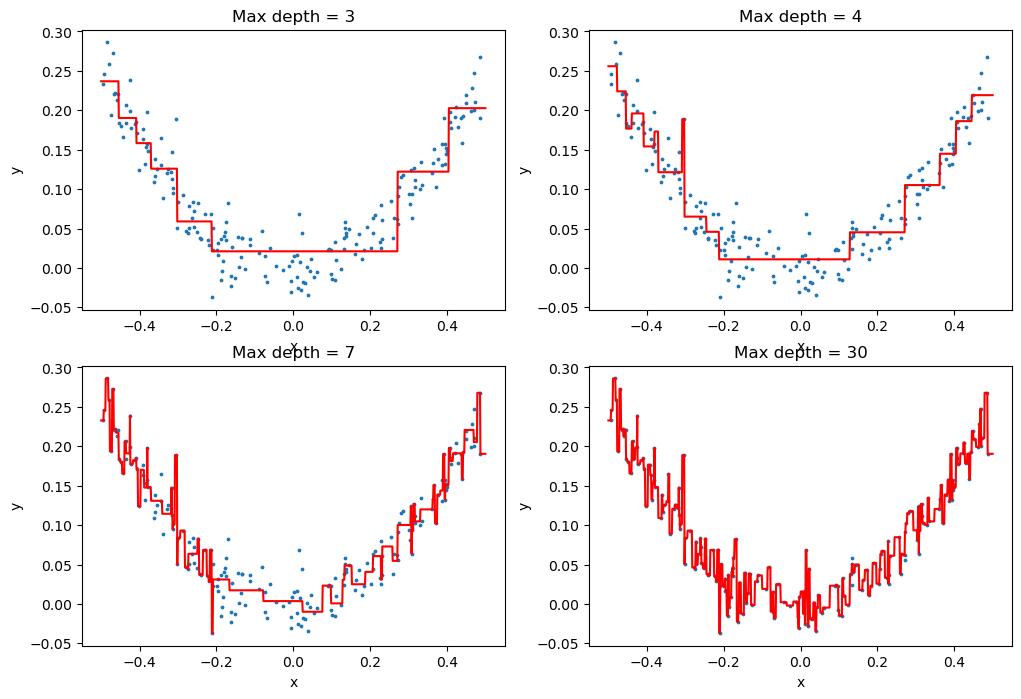

In [12]:
x_test = np.linspace(-0.5, 0.5, 1000).reshape(-1, 1)

fig = plt.figure(figsize=(12, 8))

for idx, max_depth in enumerate([3, 4, 7, 30]):

    fig.add_subplot(2, 2, idx+1)

    model = DecisionTreeRegressor(max_depth=max_depth)
    
    model.fit(x, y)
    y_pred = model.predict(x_test)
    
    plt.plot(x_test, y_pred, c='r')
    plt.scatter(x, y, s=3)
    plt.title(f'Max depth = {max_depth}')
    plt.xlabel('x')
    plt.ylabel('y')

As can be seen in the visualization above, the first indications for overfitting appear already at a maximum tree depth of 4 (note the wobbles in the left half of the signal). With increasing tree depth, overfitting becomes more and more severe.

Decision Trees make very few assumptions about the training data (as opposed to linear models, which obviously assume that the data is linear, for example). If left unconstrained, the tree structure will adapt itself to the training data, fitting it very
closely, and most likely overfitting it. Such a model is often called a **nonparametric model**, not because it does not have any parameters (it often has a lot) but because the number of parameters is not determined prior to training, so the model structure is free to stick closely to the data. In contrast, a parametric model such as a linear model has a predetermined number of parameters, so its degree of freedom is limited, reducing the risk of overfitting (but increasing the risk of underfitting).

To avoid overfitting the training data, you need to **restrict the Decision Tree's freedom**
during training. This is called **regularization**. The regularization hyperparameters depend on the algorithm used, but generally you can at least restrict the maximum depth of the Decision Tree. In Scikit-Learn, this is controlled by the `max_depth` hyperparameter (the default value is `None`, which means unlimited).
Reducing `max_depth` will regularize the model and thus reduce the risk of overfitting.

The class has a few other parameters that similarly restrict the shape of the Decision Tree: 

- `min_samples_split`: The minimum number of samples a node must have before it can be split
- `min_samples_leaf`: The minimum number of samples a leaf node must have
- `min_weight_fraction_leaf`: Same as `min_samples_leaf` but expressed as a fraction of the total number of weighted instances
- `max_leaf_nodes`: Maximum number of leaf nodes
- `max_features`: Maximum number of features that are evaluated for splitting at each node). Increasing `min_*` hyperparameters or reducing `max_*` hyperparameters will regularize the model.

**Hint:** Another way of regularizing a decision tree is by first constructing a tree without restrictions and then removing unnecessary nodes. This principle is referred to as **pruning**.

**The following code block illustrates the regularization effect of `min_samples_leaf` on the model:**

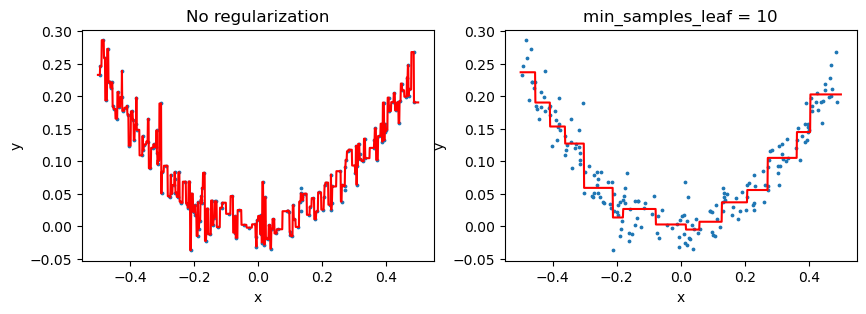

In [13]:
x_test = np.linspace(-0.5, 0.5, 1000).reshape(-1, 1)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))

# We do not restrict the maximum depth of the tree (default)
model = DecisionTreeRegressor(max_depth=None)
reg_model = DecisionTreeRegressor(max_depth=None, min_samples_leaf=10)

model.fit(x, y)
reg_model.fit(x, y)

y_pred = model.predict(x_test)
y_reg_pred = reg_model.predict(x_test)

ax[0].plot(x_test, y_pred, c='r')
ax[1].plot(x_test, y_reg_pred, c='r')

ax[0].scatter(x, y, s=3)
ax[1].scatter(x, y, s=3)
ax[0].set_title('No regularization')
ax[1].set_title('min_samples_leaf = 10')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')

plt.show()

On the left, the Decision Tree is trained with the default hyperparameters (i.e., no restrictions), and on the right the Decision Tree is trained with `min_samples_leaf=10`. It is quite obvious that the model on the left is overfitting, and the model on the right will probably generalize better.